# UBC Image Analysis

* This is an exploratory notebook for reading in single images/sets for analysis and testing out different processing techniques
* 11/21/23: Need to identify mostly saturated images and remove from dataset
    * Filter to only look at the ones that exceed a threshold
        * sum values over channnels, divide by num pixels * channels and then /255 to normalize.
        * Start with 87.5%



# Installs

In [18]:
# for IEEE publication style
!pip install -q scienceplots

In [19]:
!sudo apt-get -q update

Hit:1 http://security.ubuntu.com/ubuntu focal-security InRelease
Get:2 https://packages.cloud.google.com/apt cloud-sdk InRelease [6361 B]
Hit:3 http://packages.cloud.google.com/apt gcsfuse-focal InRelease
Hit:4 http://archive.ubuntu.com/ubuntu focal InRelease
Hit:5 http://archive.ubuntu.com/ubuntu focal-updates InRelease
Hit:6 http://archive.ubuntu.com/ubuntu focal-backports InRelease
Fetched 6361 B in 1s (7062 B/s)
Reading package lists...


In [20]:
!sudo apt-get install -y libvips

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Note, selecting 'libvips42' instead of 'libvips'
libvips42 is already the newest version (8.9.1-2).
0 upgraded, 0 newly installed, 0 to remove and 53 not upgraded.


In [21]:
!pip install pyvips

# Imports

In [22]:
import os
import gc
import shutil
from glob import glob
from os import path

import cv2
import numpy as np
import pandas as pd

import scienceplots
import matplotlib.pyplot as plt
plt.style.use(['science','no-latex'])
import seaborn as sns
import plotly.express as px

from tqdm.auto import tqdm

pd.set_option('display.float_format', '{:.2f}'.format)

import pyvips
pyvips.__version__

'2.2.1'

# Load Datasets

* First task is to look at the Look at 512 and 256 options for now, adding single tile datasets
* Start with the 256 single tile dataset (smallest)

In [23]:
img_dir_256 = '/kaggle/input/ubc-ocean-256px-single-random-tile-tma-reduced-2x/kaggle/working/new_train/'

img_files_256 = glob(img_dir_256 + '*.png')
len(img_files_256)

538

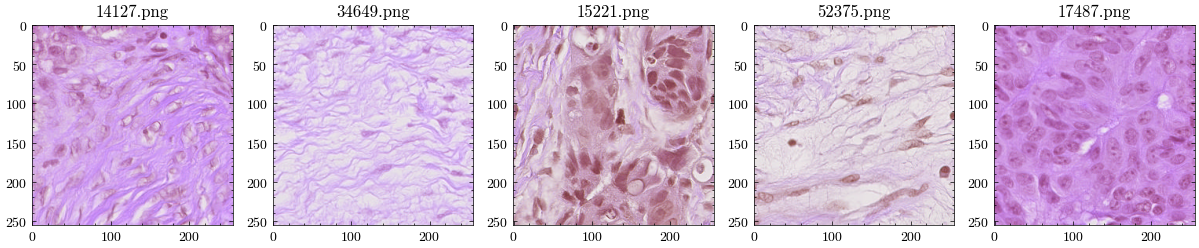

In [24]:
# look at first 5 images
plt.figure(figsize=(15,3))
for i in range(5):
    plt.subplot(1,5,i+1)
    im = cv2.imread(img_files_256[i])
    plt.imshow(im)
    plt.title(img_files_256[i].split('/')[-1])

## Look at individual R,G,B channels
* Can we get different info from looking at individual channels?
* Look at ratios of sums of channels

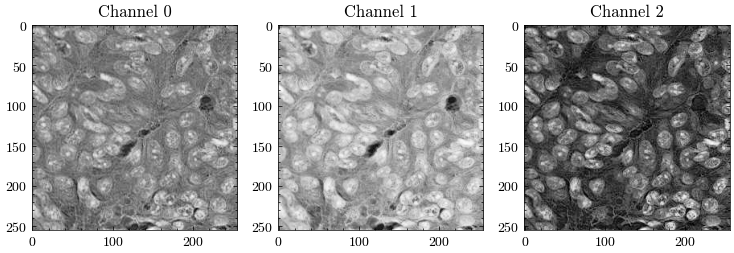

In [25]:
# in cv2, im is a 256x256x3 numpy array (for 256 px images)
plt.figure(figsize=(9,3))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(im[:,:,i],cmap='Greys')
    plt.title(f'Channel {i}')

In [26]:
# RGB Ratios
ratios = []
for i in range(3):
    ratios.append(im)
    

## Compute Percent Saturation

In [27]:
def percent_saturation(im):

    tot_pixels = 256**2
    #print(f'total pixels: {tot_pixels}')
    tot_intensity = im.sum()/(255*3)
    percent_intensity = 100*tot_intensity/tot_pixels
    #print(f'File {file.split("/")[-1]}, Percent intensity = {percent_intensity:.2f}%')
    
    return percent_intensity

## Create a list of intensities

In [28]:
intensities = []
for file in img_files_256:
    im = cv2.imread(file)
    p = percent_saturation(im)
    intensities.append([file,file.split('/')[-1],p])
    
intensities_df = pd.DataFrame(intensities,columns=['file_name','image','pct_intensity'])
intensities_df.head()

,file_name,image,pct_intensity
0,/kaggle/input/ubc-ocean-256px-single-random-ti...,14127.png,77.20
1,/kaggle/input/ubc-ocean-256px-single-random-ti...,34649.png,85.78
2,/kaggle/input/ubc-ocean-256px-single-random-ti...,15221.png,71.33
3,/kaggle/input/ubc-ocean-256px-single-random-ti...,52375.png,82.95
4,/kaggle/input/ubc-ocean-256px-single-random-ti...,17487.png,71.56


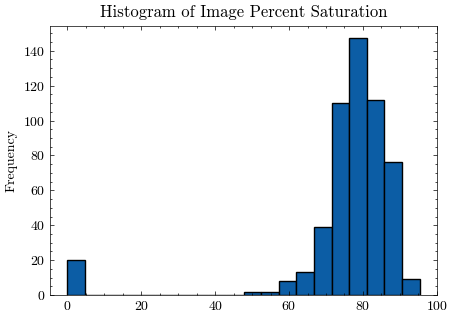

In [29]:
plt.figure(figsize=(5,3.5))
intensities_df.pct_intensity.plot(kind='hist',bins=20,ec='k')
plt.title('Histogram of Image Percent Saturation')
plt.show()

## Look for Zero intensities
* Need to remove these from the training sets too.

Number of images with zero saturation = 20


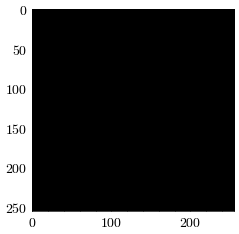

In [30]:
# there are 20 in the 256 single tile dataset that are zero
zeros_df = intensities_df[intensities_df.pct_intensity == 0.0]
print(f'Number of images with zero saturation = {len(zeros_df)}')
im0 = cv2.imread(zeros_df.file_name.iloc[0])
plt.imshow(im0);

## Look at images with high saturation

In [47]:
thresh = 87.5
sat_df = intensities_df[intensities_df.pct_intensity > thresh]
print(f'Number of images > {thresh}% saturation = {len(sat_df)}')
sat_df.head(5) #len(sat_df))


Number of images > 87.5% saturation = 62


,file_name,image,pct_intensity
5,/kaggle/input/ubc-ocean-256px-single-random-ti...,32112.png,88.82
11,/kaggle/input/ubc-ocean-256px-single-random-ti...,63429.png,87.99
19,/kaggle/input/ubc-ocean-256px-single-random-ti...,29888.png,88.64
23,/kaggle/input/ubc-ocean-256px-single-random-ti...,49281.png,89.91
43,/kaggle/input/ubc-ocean-256px-single-random-ti...,12244.png,95.09


In [48]:
# image 10143.png is a uniform grey that has intensity 89.9, look at std as well?
#plt.imshow(cv2.imread(sat_df[sat_df.image == '10143.png'].file_name.values[0]))

## Look at images > 87.5% saturation

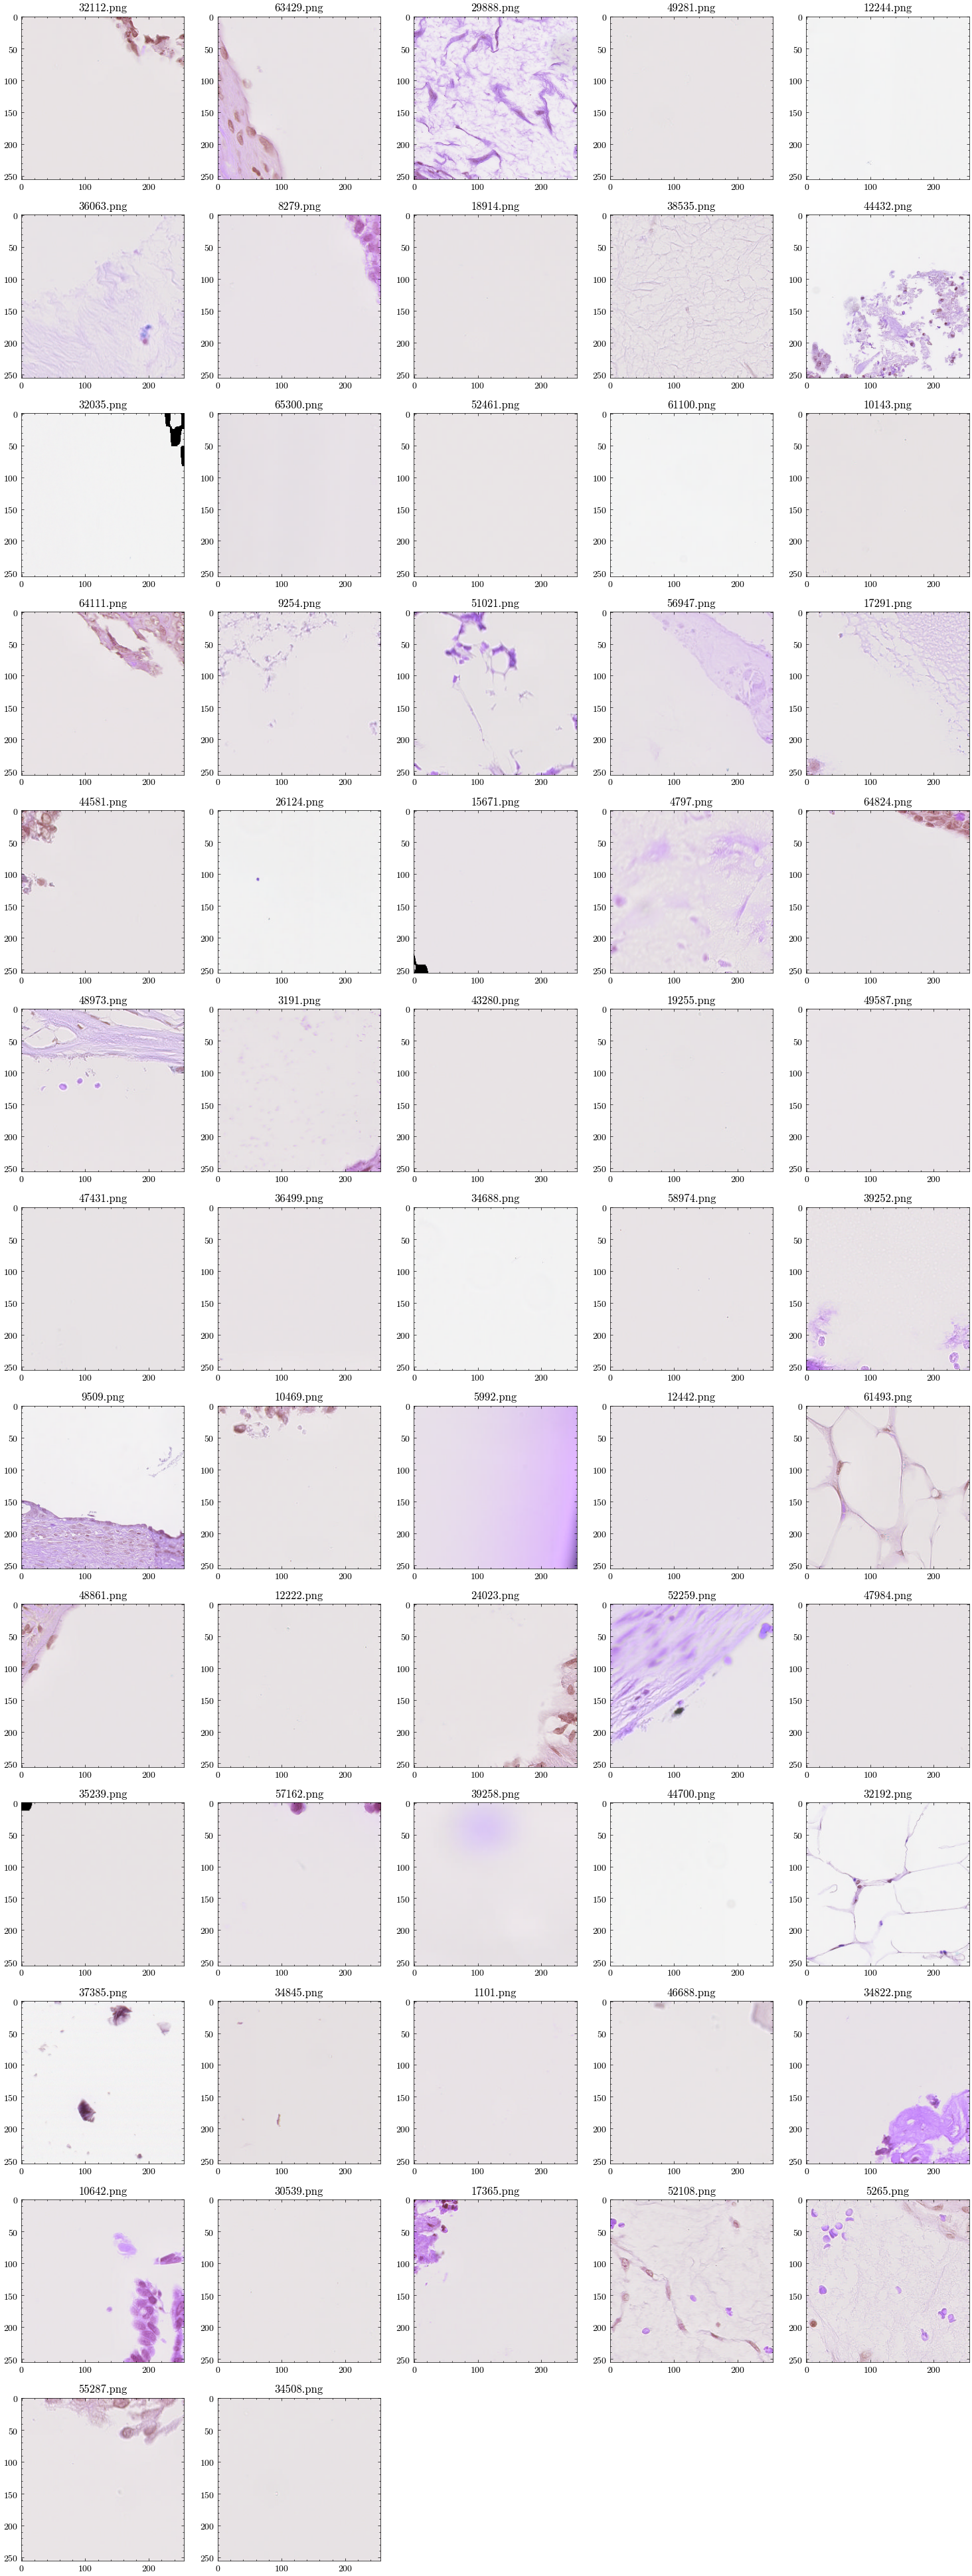

In [49]:
rows = int(np.ceil(len(sat_df)/5)) 
plt.figure(figsize=(15,3*rows),tight_layout=True) 
for i,file in enumerate(sat_df.file_name): 
    plt.subplot(rows,5,i+1) 
    im = cv2.imread(file)
    plt.imshow(im)
    plt.title(file.split('/')[-1])
